## Library Imports and Dependencies

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
import rdkit
import mols2grid
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
%matplotlib inline 

# ML models
import torch
from torch.nn import Linear, Dropout
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, TopKPooling, global_max_pool, global_mean_pool
from torch_geometric.nn import GINConv, GATConv, GraphConv
from torch_geometric.nn import GlobalAttention
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_smiles
from torch_geometric.nn import AttentiveFP
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Set the seed value
random_seed = 50

# Ensure reproducibility across PyTorch (CPU & GPU)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Ensure reproducibility for NumPy
np.random.seed(random_seed)

# Ensure deterministic behavior in PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
df = pd.read_csv('polymer_tg_tm.csv')
df.shape

(1563, 3)

In [4]:
df

,SMILES,Tg,Tm
0,*C*,-54.0,131.0
1,*CC(*)C,-3.0,164.0
2,*CC(*)CC,-24.1,115.5
3,*CC(*)CCC,-37.0,80.0
4,*CC(*)C(C)C,60.0,306.0
...,...,...,...
1558,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)F,75.0,187.0
1559,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,63.0,171.0
1560,*CC(*)(F)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,6.0,91.0
1561,*CC(*)(F)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,53.0,104.0


## Data preprocessing

In [5]:
def calculate_descriptors(mol):
    if mol is None:
        return torch.zeros(1, 25, dtype=torch.float)

    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.Chi0(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.RingCount(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.NHOHCount(mol),
        Descriptors.NOCount(mol),

        # Additional ones
        Descriptors.NumAliphaticRings(mol),
        Descriptors.NumAromaticRings(mol),
        Descriptors.BalabanJ(mol),
        Descriptors.HallKierAlpha(mol),
        Descriptors.MolMR(mol),
        Descriptors.LabuteASA(mol),

        # VSA-based descriptors (pick a few representative ones)
        Descriptors.PEOE_VSA1(mol),
        Descriptors.PEOE_VSA2(mol),
        Descriptors.SMR_VSA1(mol),
        Descriptors.SMR_VSA2(mol),
        Descriptors.EState_VSA1(mol),
        Descriptors.EState_VSA2(mol),
        Descriptors.VSA_EState1(mol)
    ]

    return torch.tensor(descriptors, dtype=torch.float).view(1, -1)

In [6]:
descriptor_list = []

for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    desc = calculate_descriptors(mol)
    descriptor_list.append(desc)

# Convert to (N, 12) array
descriptor_matrix = torch.cat(descriptor_list, dim=0).numpy()

# Standardize
scaler = StandardScaler()
desc_scaled = scaler.fit_transform(descriptor_matrix)

In [7]:
pca = PCA(n_components=12)  # You can tune this
desc_pca = pca.fit_transform(desc_scaled)

In [8]:
# Initialize an empty list to store the graphs
graph_list = []

for i, smile in enumerate(df['SMILES']):
    g = from_smiles(smile)
    g.x = g.x.float()

    # PCA-transformed descriptor
    desc_tensor = torch.tensor(desc_pca[i], dtype=torch.float).view(1, -1)
    
    y = torch.tensor([df['Tg'][i], df['Tm'][i]], dtype=torch.float).view(1, -1)

    g.y = y
    g.descriptors = desc_tensor
    graph_list.append(g)

In [9]:
 graph_list[0]

Data(x=[3, 9], edge_index=[2, 4], edge_attr=[4, 3], smiles='*C*', y=[1, 2], descriptors=[1, 12])

## GNN Definition and Model Training

In [10]:
# Define the ratio for splitting the dataset (80% for training, 20% for validation)
train_ratio = 0.80

# Calculate the total number of samples in the dataset
dataset_size = len(graph_list)

# Calculate the number of samples for the training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Set a random seed for reproducibility
random_seed = 66
generator = torch.Generator().manual_seed(random_seed)

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(graph_list, [train_size, val_size], generator=generator)

In [11]:
# Create the DataLoaders for the train and val sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [12]:
class HybridGNN(nn.Module):
    def __init__(self, hidden_channels, descriptor_size, dropout_rate):
        super(HybridGNN, self).__init__()

        # GINConv (good for strong structure modeling)
        self.conv1 = GINConv(Linear(9, hidden_channels))  # Assuming 9 input node features

        # GATConv (learns importance weights for neighbors)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=2, concat=False)

        # GraphConv (stable refinement)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)

        # GELU and dropout
        self.gelu = nn.GELU()
        self.dropout = Dropout(p=dropout_rate)

        # Combine graph embedding + descriptor
        combined_size = hidden_channels * 2 + descriptor_size

        self.shared_fc = nn.Sequential(
            Linear(combined_size, 128),
            nn.GELU(),
            Dropout(dropout_rate)
        )

        self.tg_head = nn.Sequential(
            Linear(128, 64),
            nn.GELU(),
            Dropout(dropout_rate),
            Linear(64, 1)
        )

        self.tm_head = nn.Sequential(
            Linear(128, 64),
            nn.GELU(),
            Dropout(dropout_rate),
            Linear(64, 1)
        )

    def forward(self, x, edge_index, batch_index, descriptors):
        h = self.gelu(self.conv1(x, edge_index))
        h = self.gelu(self.conv2(h, edge_index))
        h = self.gelu(self.conv3(h, edge_index))

        h = torch.cat([
            global_max_pool(h, batch_index),
            global_mean_pool(h, batch_index)
        ], dim=1)

        combined = torch.cat([h, descriptors], dim=1)
        shared_features = self.shared_fc(combined)

        tg_out = self.tg_head(shared_features)
        tm_out = self.tm_head(shared_features)
        return torch.cat([tg_out, tm_out], dim=1), shared_features

In [13]:
# Set up the device (GPU if available, otherwise CPU) and initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with specified parameters and move it to the appropriate device
model = HybridGNN(hidden_channels=128, descriptor_size=12, dropout_rate=0.6).to(device)

# Set up the NAdam optimizer with learning rate and weight decay for regularization
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0008, weight_decay=0.0)

# Set up a Scheduler
scheduler = StepLR(optimizer, step_size=15, gamma=0.75)

In [14]:
def train(loader):
    total_loss = total_samples = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Model predictions: shape (batch_size, 2) -> [Tg, Tm]
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)

        # MSE loss for both targets
        loss = F.mse_loss(out, data.y)

        loss.backward()
        optimizer.step()

        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs

    return np.sqrt(total_loss / total_samples)

In [15]:
@torch.no_grad()  # Disable gradient tracking for validation (improves speed and reduces memory)
def val(loader):
    model.eval()  # Set the model to evaluation mode (e.g., disables dropout)
    
    total_samples = total_loss = 0 

    # Iterate through the validation dataset
    for data in loader:
        data = data.to(device)  # Move data to the appropriate device (CPU or GPU)

        # Forward pass through the model
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)

        # Compute mean squared error (MSE) for the batch
        loss = F.mse_loss(out, data.y)  # By default, reduction='mean'

        # Accumulate the weighted loss (loss * number of graphs in batch)
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs

    # Compute and return root mean squared error (RMSE)
    return np.sqrt(total_loss / total_samples)

In [16]:
warnings.filterwarnings("ignore", category=UserWarning)


# Initialize lists to store training and val scores (RMSE values)
score_train = []
score_val = []

# Set the number of epochs for training
epochs = 200

# Loop over each epoch for training
for epoch in range(epochs):
    
    # Train the model and get the training RMSE
    train_rmse = train(train_loader)

    # Adjust learning rate
    scheduler.step()

    # Validate the model and get the val RMSE
    val_rmse = val(val_loader)

    # Append the training RMSE and val RMSE to their respective lists
    score_train.append(train_rmse)
    score_val.append(val_rmse)

    # Print the progress of the training process (epoch number, train loss, val loss)
    print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_rmse:.4f}, '
          f'Validation Loss: {val_rmse:.4f}')

Epoch: 1/200 | Train Loss: 133.0118, Validation Loss: 92.8740
Epoch: 2/200 | Train Loss: 86.5011, Validation Loss: 86.5674
Epoch: 3/200 | Train Loss: 81.3303, Validation Loss: 111.5925
Epoch: 4/200 | Train Loss: 79.0967, Validation Loss: 75.8553
Epoch: 5/200 | Train Loss: 75.6497, Validation Loss: 75.5918
Epoch: 6/200 | Train Loss: 75.0400, Validation Loss: 72.7567
Epoch: 7/200 | Train Loss: 72.9754, Validation Loss: 77.7037
Epoch: 8/200 | Train Loss: 72.4491, Validation Loss: 100.5613
Epoch: 9/200 | Train Loss: 71.4188, Validation Loss: 71.0331
Epoch: 10/200 | Train Loss: 70.5151, Validation Loss: 74.1315
Epoch: 11/200 | Train Loss: 70.4290, Validation Loss: 69.9011
Epoch: 12/200 | Train Loss: 68.7945, Validation Loss: 85.9559
Epoch: 13/200 | Train Loss: 68.5462, Validation Loss: 76.9708
Epoch: 14/200 | Train Loss: 69.5596, Validation Loss: 79.0486
Epoch: 15/200 | Train Loss: 67.7763, Validation Loss: 75.2707
Epoch: 16/200 | Train Loss: 66.9171, Validation Loss: 74.2459
Epoch: 17/200 

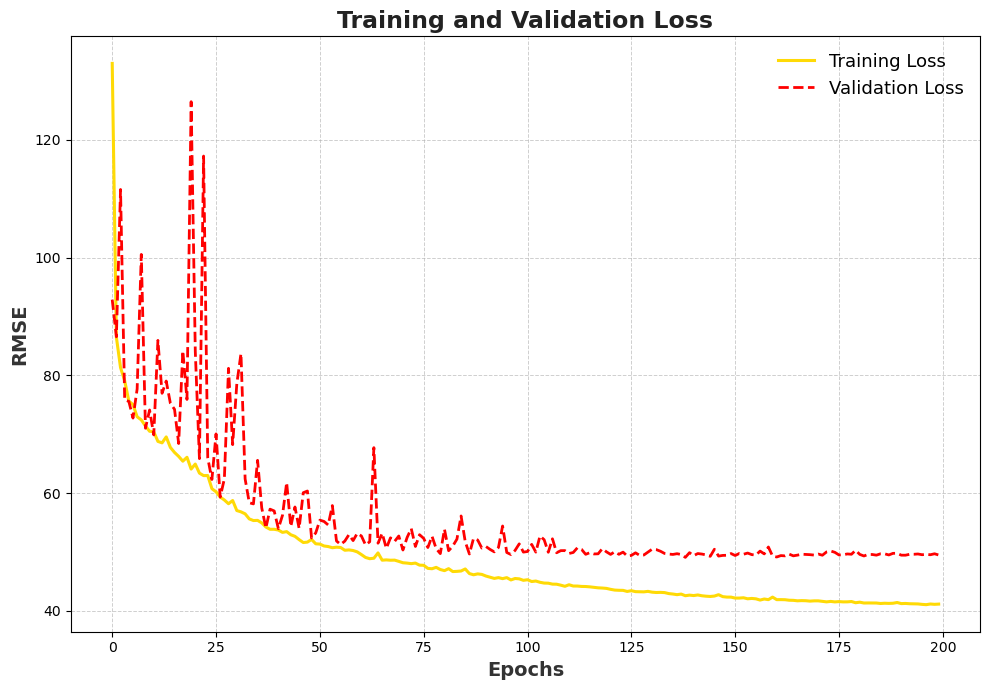

In [17]:
#Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation losses with improved styling
plt.plot(range(epochs), score_train, label='Training Loss', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), score_val, label='Validation Loss', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title with a bold but clean look
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('RMSE', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Loss', fontsize=17, fontweight='bold', color='#222222')

# Improve grid visibility but keep it subtle
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Improve legend (slightly larger, no border)
plt.legend(loc='upper right', fontsize=13, frameon=False)

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

## Model Evaluation & Visualization

In [18]:
@torch.no_grad()  # Disable gradient computation for evaluation
def eval(loader):
    preds = []  # Store model predictions
    trues = []  # Store true target values
    smi = []    # Store SMILES strings
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the correct device (GPU/CPU)
        
        # Get model predictions
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors) 
        
        # Append predictions and true labels
        preds.append(out.cpu())
        trues.append(data.y.cpu())
        
        # Append SMILES strings
        smi.extend(data.smiles)  # extend, not append, since it's a list of strings
    
    # Convert to NumPy arrays
    preds = torch.cat(preds, dim=0).numpy()
    trues = torch.cat(trues, dim=0).numpy()
    
    # Build DataFrame with separate columns for each target
    results = pd.DataFrame({
        'smiles': smi,
        'Tg': trues[:, 0],
        'Tm': trues[:, 1],
        'Tg pred': preds[:, 0],
        'Tm pred': preds[:, 1],
    })
    
    return results

In [19]:
val_res = eval(val_loader)

In [20]:
val_res

,smiles,Tg,Tm,Tg pred,Tm pred
0,*CCCCCCCCCCCNC(=O)CCCCCCCCCCCCCCCCCCC(=O)N*,29.0,167.000000,24.515287,157.255005
1,*Oc1cc(OC(=O)c2ccc(OC)cc2)c(OC(=O)CCCC(*)=O)cc...,88.0,220.000000,95.841232,237.174484
2,*CCCCCCCCCCCC(=O)Oc1ccc(OC(=O)c2ccc3c(c2)C(=O)...,58.0,172.500000,77.688828,194.310226
3,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,63.0,171.000000,57.883469,149.129456
4,*Oc1ccc(C(c2ccc(OC(=O)c3ccc(C(c4ccc(C(*)=O)cc4...,135.0,181.000000,178.791626,265.092712
...,...,...,...,...,...
308,*CCCCCCCCCCOC(=O)c1ccc2cc(C(=O)O*)ccc2c1,50.5,144.000000,40.174793,135.518936
309,*CCCOC(=O)NCCCCCCNC(=O)O*,55.0,168.000000,46.600830,179.931824
310,*CCCCO*,-80.0,37.299999,-48.110043,55.842876
311,*CCCNC(=O)C(NC(=O)C(Cc1ccccc1)NC(=O)CCCCCCCCC(...,66.0,238.000000,82.899399,217.887985


In [21]:
def evaluate_preds(y_true, y_preds):
    # Calculate metrics
    metrics = {"R2": r2_score(y_true, y_preds),
               "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
               "MAE": mean_absolute_error(y_true, y_preds)}

    # Print the metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Return rounded metrics
    return {metric: round(value, 3) for metric, value in metrics.items()}

In [22]:
evaluate_preds(val_res['Tg'], val_res['Tg pred']);

R2: 0.848
RMSE: 36.290
MAE: 25.757


In [23]:
evaluate_preds(val_res['Tm'], val_res['Tm pred']);

R2: 0.729
RMSE: 59.854
MAE: 43.327


In [24]:
def run_cross_validation(graph_list, train_fn, val_fn, eval_fn,
                         k_folds, n_epochs, batch_size, seed):

    warnings.filterwarnings("ignore", category=UserWarning)
    torch.manual_seed(seed)
    np.random.seed(seed)

    graph_list = list(graph_list)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    tg_rmse_list, tm_rmse_list = [], []
    tg_r2_list, tm_r2_list = [], []

    print(f"\n=== Starting {k_folds}-Fold Cross-Validation ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(graph_list)):
        print(f"\n--- Fold {fold + 1}/{k_folds} ---")

        train_dataset = [graph_list[i] for i in train_idx]
        val_dataset = [graph_list[i] for i in val_idx]

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Define global variables for compatibility with your existing train/val/eval
        global model, optimizer, scheduler, device

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = HybridGNN(hidden_channels=128, descriptor_size=12, dropout_rate=0.6).to(device)
        optimizer = torch.optim.NAdam(model.parameters(), lr=0.0008, weight_decay=0.0)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.75)

        for epoch in range(n_epochs):
            train_rmse = train_fn(train_loader)
            scheduler.step()
            val_rmse = val_fn(val_loader)

        fold_df = eval_fn(val_loader)
        tg_rmse = mean_squared_error(fold_df['Tg'], fold_df['Tg pred']) ** 0.5
        tm_rmse = mean_squared_error(fold_df['Tm'], fold_df['Tm pred']) ** 0.5
        tg_r2 = r2_score(fold_df['Tg'], fold_df['Tg pred'])
        tm_r2 = r2_score(fold_df['Tm'], fold_df['Tm pred'])

        tg_rmse_list.append(tg_rmse)
        tm_rmse_list.append(tm_rmse)
        tg_r2_list.append(tg_r2)
        tm_r2_list.append(tm_r2)

        print(f"Fold {fold+1} Results:")
        print(f"  Tg R²: {tg_r2:.4f} | RMSE: {tg_rmse:.4f}")
        print(f"  Tm R²: {tm_r2:.4f} | RMSE: {tm_rmse:.4f}")

    def summary(metric_list, name):
        mean = np.mean(metric_list)
        std = np.std(metric_list)
        return f"{name}: {mean:.4f} ± {std:.4f}"

    print("\n=== Cross-Validation Summary ===")
    print(summary(tg_r2_list, "Tg R²"))
    print(summary(tm_r2_list, "Tm R²"))
    print(summary(tg_rmse_list, "Tg RMSE"))
    print(summary(tm_rmse_list, "Tm RMSE"))

In [25]:
run_cross_validation(
    graph_list=graph_list,
    train_fn=train,
    val_fn=val,
    eval_fn=eval,
    k_folds=5,
    n_epochs=200,
    batch_size=16,
    seed=50
)


=== Starting 5-Fold Cross-Validation ===

--- Fold 1/5 ---
Fold 1 Results:
  Tg R²: 0.7941 | RMSE: 39.8062
  Tm R²: 0.7217 | RMSE: 60.6321

--- Fold 2/5 ---
Fold 2 Results:
  Tg R²: 0.8086 | RMSE: 43.6028
  Tm R²: 0.7162 | RMSE: 62.7329

--- Fold 3/5 ---
Fold 3 Results:
  Tg R²: 0.8014 | RMSE: 39.5267
  Tm R²: 0.6740 | RMSE: 63.4648

--- Fold 4/5 ---
Fold 4 Results:
  Tg R²: 0.8196 | RMSE: 36.4341
  Tm R²: 0.6839 | RMSE: 61.1034

--- Fold 5/5 ---
Fold 5 Results:
  Tg R²: 0.8036 | RMSE: 40.8025
  Tm R²: 0.6758 | RMSE: 65.4412

=== Cross-Validation Summary ===
Tg R²: 0.8055 ± 0.0085
Tm R²: 0.6943 ± 0.0205
Tg RMSE: 40.0345 ± 2.3063
Tm RMSE: 62.6749 ± 1.7276


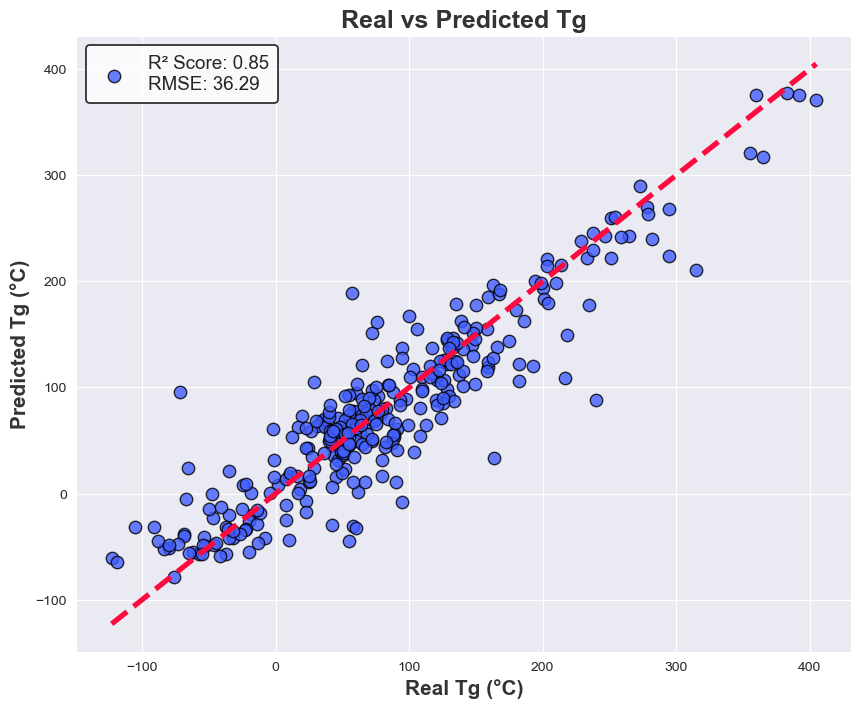

In [26]:
# Compute R² score and RMSE
r2 = r2_score(val_res['Tg'], val_res['Tg pred'])
rmse = np.sqrt(mean_squared_error(val_res['Tg'], val_res['Tg pred']))

# Choose a style for the plot
sns.set_style('darkgrid')  # Dark grid background for the plot
sns.set_palette("crest")  # Set the color palette for the plot

# Set figure size
plt.figure(figsize=(10, 8))

# Scatter plot: Actual vs Predicted values
plt.scatter(val_res['Tg'], val_res['Tg pred'], color='#415eff', alpha=0.8, edgecolors='black', s=80)

# Plot the line of perfect prediction (45-degree line)
plt.plot([min(val_res['Tg']), max(val_res['Tg'])], 
         [min(val_res['Tg']), max(val_res['Tg'])], 
         color='#ff0a3f', linestyle='--', lw=3.8, label="Perfect Fit (y=x)")  

# Create legend text
legend_text = f'R² Score: {r2:.2f}\nRMSE: {rmse:.2f}'

# Add a professional-looking legend in the **top-left corner**
legend = plt.legend([legend_text], loc="upper left", fontsize=13.5, 
                    frameon=True, edgecolor="black", facecolor="white", 
                    borderpad=0.5)

# Increase border thickness
legend.get_frame().set_linewidth(1.3)

# Title and labels
plt.title('Real vs Predicted Tg', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Real Tg (°C)', fontsize=15, fontweight='bold', color='#333333')
plt.ylabel('Predicted Tg (°C)', fontsize=15, fontweight='bold', color='#333333')

# Display grid and plot
plt.grid(True)
plt.show()

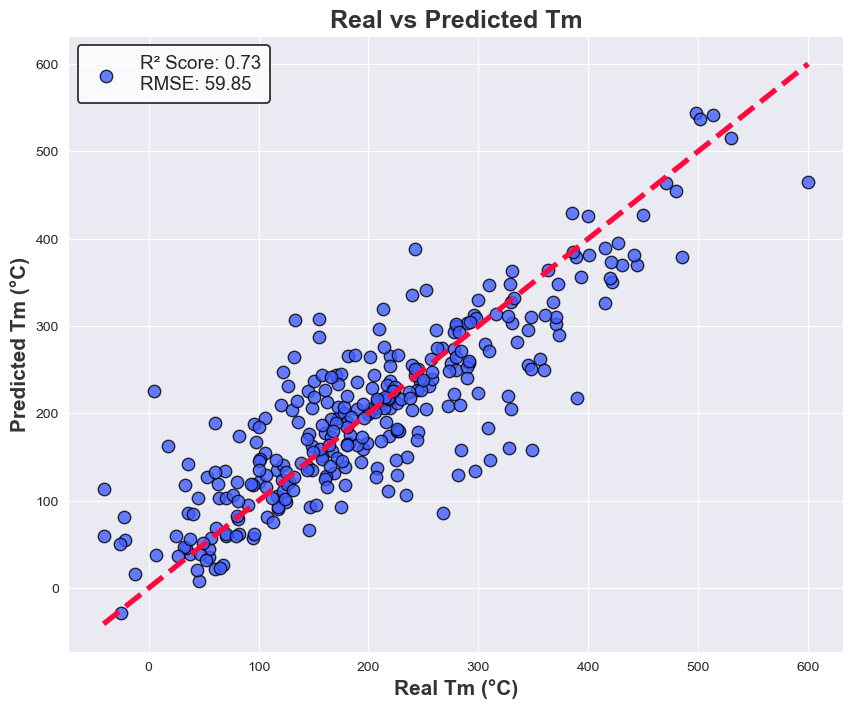

In [27]:
# Compute R² score and RMSE
r2 = r2_score(val_res['Tm'], val_res['Tm pred'])
rmse = np.sqrt(mean_squared_error(val_res['Tm'], val_res['Tm pred']))

# Choose a style for the plot
sns.set_style('darkgrid')  # Dark grid background for the plot
sns.set_palette("crest")  # Set the color palette for the plot

# Set figure size
plt.figure(figsize=(10, 8))

# Scatter plot: Actual vs Predicted values
plt.scatter(val_res['Tm'], val_res['Tm pred'], color='#415eff', alpha=0.8, edgecolors='black', s=80)

# Plot the line of perfect prediction (45-degree line)
plt.plot([min(val_res['Tm']), max(val_res['Tm'])], 
         [min(val_res['Tm']), max(val_res['Tm'])], 
         color='#ff0a3f', linestyle='--', lw=3.8, label="Perfect Fit (y=x)")  

# Create legend text
legend_text = f'R² Score: {r2:.2f}\nRMSE: {rmse:.2f}'

# Add a professional-looking legend in the **top-left corner**
legend = plt.legend([legend_text], loc="upper left", fontsize=13.5, 
                    frameon=True, edgecolor="black", facecolor="white", 
                    borderpad=0.5)

# Increase border thickness
legend.get_frame().set_linewidth(1.3)

# Title and labels
plt.title('Real vs Predicted Tm', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Real Tm (°C)', fontsize=15, fontweight='bold', color='#333333')
plt.ylabel('Predicted Tm (°C)', fontsize=15, fontweight='bold', color='#333333')

# Display grid and plot
plt.grid(True)
plt.show()